<a href="https://colab.research.google.com/github/calvinpozderac/TTTAZ/blob/main/TTT_AZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.amp import autocast, GradScaler
import math
import random
from collections import deque, defaultdict
import time
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# --- Optimal AI ---
# Implementing a perfect AI for a new game might be challenging or impossible
# for complex games due to the state space size. For simple games like Tic-Tac-Toe,
# a minimax implementation is feasible for evaluation.
class OptimalAI:
    """Perfect minimax AI for Tic-Tac-Toe with caching"""

    def __init__(self, game):
        self.game = game
        self.minimax_cache = {}  # Cache for minimax values
        self.move_cache = {}     # Cache for best moves
        self.precompute_all_positions()

    def precompute_all_positions(self):
        """Precompute all possible positions for instant lookup"""
        print("Precomputing optimal moves for all positions...")

        def generate_all_states(state, player):
            """Recursively generate and evaluate all possible game states"""
            # Use a more robust string representation for state keys
            state_key = (np.array2string(state.flatten(), separator=',', max_line_width=np.inf), player)

            if state_key in self.minimax_cache:
                return

            # Check if game is over
            result = self.game.get_game_ended(state, 1) # Evaluate from player 1's perspective
            if result is not None:
                # Store the result from the perspective of the current player
                self.minimax_cache[state_key] = result * player
                return

            # Find best move and value for this position
            best_score = float('-inf') if player == 1 else float('inf')
            best_move = None

            for action in range(9):
                if state.flatten()[action] == 0:
                    next_state, next_player = self.game.get_next_state(state, action, player)

                    # Recursively evaluate next state
                    generate_all_states(next_state, next_player)

                    next_state_key = (np.array2string(next_state.flatten(), separator=',', max_line_width=np.inf), next_player)
                    score = self.minimax_cache[next_state_key] * next_player # Get score from current player's perspective

                    if player == 1 and score > best_score:
                        best_score = score
                        best_move = action
                    elif player == -1 and score < best_score:
                        best_score = score
                        best_move = action

            # Cache the results
            self.minimax_cache[state_key] = best_score
            self.move_cache[state_key] = best_move

        # Generate all states starting from empty board
        initial_state = self.game.get_initial_state()
        generate_all_states(initial_state, 1)

        print(f"Precomputed {len(self.move_cache)} positions")

    def minimax(self, state, depth, maximizing_player):
        """Minimax with caching (alpha-beta pruning removed)"""
        # Use a more robust string representation for state keys
        state_key = (np.array2string(state.flatten(), separator=',', max_line_width=np.inf), 1 if maximizing_player else -1)


        if state_key in self.minimax_cache:
            return self.minimax_cache[state_key]

        result = self.game.get_game_ended(state, 1 if maximizing_player else -1)

        if result is not None:
            self.minimax_cache[state_key] = result * (1 if maximizing_player else -1) # Store from current player's perspective
            return self.minimax_cache[state_key]

        if maximizing_player:
            max_eval = float('-inf')
            for action in range(9):
                if state.flatten()[action] == 0:
                    next_state, _ = self.game.get_next_state(state, action, 1)
                    eval_score = self.minimax(next_state, depth + 1, False)
                    max_eval = max(max_eval, eval_score)
            self.minimax_cache[state_key] = max_eval
            return max_eval
        else:
            min_eval = float('inf')
            for action in range(9):
                if state.flatten()[action] == 0:
                    next_state, _ = self.game.get_next_state(state, action, -1)
                    eval_score = self.minimax(next_state, depth + 1, True)
                    min_eval = min(min_eval, eval_score)
            self.minimax_cache[state_key] = min_eval
            return min_eval

    def get_best_move(self, state, player):
        """Get the optimal move using cached results"""
        # Use a more robust string representation for state keys
        state_key = (np.array2string(state.flatten(), separator=',', max_line_width=np.inf), player)


        # Use precomputed move if available
        if state_key in self.move_cache:
            return self.move_cache[state_key]

        # Fallback to real-time computation (shouldn't happen after precompute)
        print(f"Warning: Position {state_key} not in cache, computing real-time for player {player}")
        best_score = float('-inf') if player == 1 else float('inf')
        best_move = None

        for action in range(9):
            if state.flatten()[action] == 0:
                next_state, _ = self.game.get_next_state(state, action, player)
                score = self.minimax(next_state, 0, player == 1) # Use player == 1 to get score from player 1's perspective

                if player == 1 and score > best_score:
                    best_score = score
                    best_move = action
                elif player == -1 and score < best_score:
                    best_score = score
                    best_move = action

        return best_move

In [5]:
# --- Game Class ---
# To extend to a new game, create a new class inheriting from a base Game class
# (or simply implement the required methods) that defines the game rules:
# - get_initial_state(): returns the starting board state
# - get_valid_moves(state): returns a boolean array of valid moves from the state
# - get_next_state(state, action, player): returns the next state and player after an action
# - get_game_ended(state, player): returns 1 for win, -1 for loss, 0 for draw, None if game continues
# - get_canonical_form(state, player): returns state from the perspective of player 1
# - get_symmetries(state, pi): returns a list of (state, policy) tuples representing board symmetries for data augmentation
class TicTacToeGame:
    """Optimized Tic-Tac-Toe game implementation"""

    def __init__(self):
        self.board_size = 3
        self.action_size = 9  # 3x3 board

    def get_initial_state(self):
        return np.zeros((3, 3), dtype=np.int8)

    def get_valid_moves(self, state):
        return (state == 0).flatten()

    def get_next_state(self, state, action, player):
        next_state = state.copy()
        row, col = action // 3, action % 3
        next_state[row, col] = player
        return next_state, -player  # Switch player

    def get_game_ended(self, state, player):
        # Check rows
        for row in range(3):
            if abs(sum(state[row])) == 3:
                return sum(state[row]) / 3  # Returns 1 or -1

        # Check columns
        for col in range(3):
            if abs(sum(state[:, col])) == 3:
                return sum(state[:, col]) / 3

        # Check diagonals
        if abs(sum(state.diagonal())) == 3:
            return sum(state.diagonal()) / 3
        if abs(sum(np.fliplr(state).diagonal())) == 3:
            return sum(np.fliplr(state).diagonal()) / 3

        # Check for draw
        if not (state == 0).any():
            return 0

        return None  # Game continues

    def get_canonical_form(self, state, player):
        return state * player

    def get_symmetries(self, state, pi):
        """Get all symmetries for data augmentation"""
        symmetries = []

        # Original
        symmetries.append((state, pi))

        # Rotations
        for k in range(1, 4):
            state_rot = np.rot90(state, k)
            pi_rot = np.rot90(pi.reshape(3, 3), k).flatten()
            symmetries.append((state_rot, pi_rot))

        # Flips
        state_flip = np.fliplr(state)
        pi_flip = np.fliplr(pi.reshape(3, 3)).flatten()
        symmetries.append((state_flip, pi_flip))

        # Rotations of flipped
        for k in range(1, 4):
            state_rot = np.rot90(state_flip, k)
            pi_rot = np.rot90(pi_flip.reshape(3, 3), k).flatten()
            symmetries.append((state_rot, pi_rot))

        return symmetries

# --- Neural Network ---
# To extend to a new game, adjust the network architecture:
# - Input shape: Match the new game's board representation.
# - Output shapes: Match the new game's action space (policy head) and value output (value head).
# - Consider different convolutional filter sizes or types if the board structure is very different.
class NeuralNetwork(nn.Module):
    """Optimized neural network for AlphaZero"""

    def __init__(self, game, num_channels=512):
        super(NeuralNetwork, self).__init__()
        self.board_size = game.board_size
        self.action_size = game.action_size
        self.num_channels = num_channels

        # Convolutional layers (adjust kernel size/padding if board size changes significantly)
        self.conv1 = nn.Conv2d(1, num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(num_channels, num_channels, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(num_channels, num_channels, 3, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.bn3 = nn.BatchNorm2d(num_channels)
        self.bn4 = nn.BatchNorm2d(num_channels)

        # Policy head (adjust output size to game.action_size)
        self.conv_policy = nn.Conv2d(num_channels, 32, 1)
        self.bn_policy = nn.BatchNorm2d(32)
        self.fc_policy = nn.Linear(32 * self.board_size * self.board_size, self.action_size)

        # Value head (adjust input size if board size changes)
        self.conv_value = nn.Conv2d(num_channels, 3, 1)
        self.bn_value = nn.BatchNorm2d(3)
        self.fc_value1 = nn.Linear(3 * self.board_size * self.board_size, 64)
        self.fc_value2 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(0.3)

    def forward(self, s):
        # Common layers
        s = s.view(-1, 1, self.board_size, self.board_size)
        s = F.relu(self.bn1(self.conv1(s)))
        s = F.relu(self.bn2(self.conv2(s)))
        s = F.relu(self.bn3(self.conv3(s)))
        s = F.relu(self.bn4(self.conv4(s)))

        # Policy head
        pi = F.relu(self.bn_policy(self.conv_policy(s)))
        pi = pi.view(pi.size(0), -1)
        pi = self.dropout(pi)
        pi = self.fc_policy(pi)
        pi = F.log_softmax(pi, dim=1)

        # Value head
        v = F.relu(self.bn_value(self.conv_value(s)))
        v = v.view(v.size(0), -1)
        v = self.dropout(v)
        v = F.relu(self.fc_value1(v))
        v = self.fc_value2(v)
        v = torch.tanh(v)

        return pi, v

# --- MCTS ---
# The MCTS class is generally game-agnostic, relying on the Game and NeuralNetwork classes.
# No major changes needed here for a new game unless the MCTS algorithm itself needs modification
# (e.g., for games with very large branching factors).
class MCTS:
    """Optimized Monte Carlo Tree Search"""

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.Qsa = {}  # Q values
        self.Nsa = {}  # Visit counts for state-action
        self.Ns = {}   # Visit counts for state
        self.Ps = {}   # Policy
        self.Es = {}   # Game ended
        self.Vs = {}   # Valid moves

    def get_action_prob(self, state, temp=1):
        """Get action probabilities and value estimate after MCTS simulations"""
        for _ in range(self.args.num_mcts_sims):
            self.search(state, 1)

        s = self.game.get_canonical_form(state, 1)
        # Use a more robust string representation for state keys
        s_str = np.array2string(s, separator=',', max_line_width=np.inf)
        counts = [self.Nsa.get((s_str, a), 0) for a in range(self.game.action_size)]

        if temp == 0:
            # Deterministic - choose best action
            best_actions = np.array(np.argwhere(counts == np.max(counts))).flatten()
            best_action = np.random.choice(best_actions)
            probs = np.zeros(len(counts))
            probs[best_action] = 1
        else:
            # Probabilistic based on temperature
            counts = np.array(counts, dtype=np.float64)
            counts = counts ** (1.0 / temp)
            probs = counts / counts.sum()

        # Calculate MCTS value estimate
        # Weighted average of action values based on visit counts
        total_visits = sum(counts)
        if total_visits > 0:
            mcts_value = 0
            for a in range(self.game.action_size):
                if (s_str, a) in self.Qsa and counts[a] > 0:
                    mcts_value += (counts[a] / total_visits) * self.Qsa[(s_str, a)]
        else:
            mcts_value = 0

        return probs, mcts_value

    def search(self, state, player):
        """MCTS search with neural network guidance"""
        s = self.game.get_canonical_form(state, player)
        # Use a more robust string representation for state keys
        s_str = np.array2string(s, separator=',', max_line_width=np.inf)


        if s_str not in self.Es:
            self.Es[s_str] = self.game.get_game_ended(s, 1) # Evaluate from player 1's perspective

        if self.Es[s_str] is not None:
            # Terminal node
            return self.Es[s_str] # Return the game result directly

        if s_str not in self.Ps:
            # Leaf node - expand using neural network
            with torch.no_grad():
                # Ensure input tensor has the correct shape (batch, channels, height, width)
                s_tensor = torch.FloatTensor(s).unsqueeze(0).unsqueeze(0).to(device)
                log_pi, v = self.nnet(s_tensor)
                pi = torch.exp(log_pi).cpu().numpy()[0]

            valid_moves = self.game.get_valid_moves(s)
            pi = pi * valid_moves  # Mask invalid moves
            pi_sum = np.sum(pi)
            if pi_sum > 0:
                pi = pi / pi_sum  # Renormalize
            else:
                # If all valid moves have zero probability, distribute probability evenly
                pi = valid_moves / np.sum(valid_moves)

            self.Ps[s_str] = pi
            self.Vs[s_str] = valid_moves
            self.Ns[s_str] = 0
            return v.item() # Return the value estimate

        # Internal node - select action using UCB
        valid_moves = self.Vs[s_str]
        cur_best = -float('inf')
        best_act = -1

        # UCB formula
        for a in range(self.game.action_size):
            if valid_moves[a]:
                if (s_str, a) in self.Qsa:
                    u = (self.Qsa[(s_str, a)] +
                         self.args.cpuct * self.Ps[s_str][a] *
                         math.sqrt(self.Ns[s_str]) / (1 + self.Nsa[(s_str, a)]))
                else:
                    u = (self.args.cpuct * self.Ps[s_str][a] *
                         math.sqrt(self.Ns[s_str] + 1e-8)) # Add epsilon to prevent division by zero

                if u > cur_best:
                    cur_best = u
                    best_act = a

        # Make move and recurse
        next_s, next_player = self.game.get_next_state(state, best_act, player) # Use original state here
        v = self.search(next_s, next_player)

        # Backup
        if (s_str, best_act) in self.Qsa:
            self.Qsa[(s_str, best_act)] = ((self.Nsa[(s_str, best_act)] *
                                          self.Qsa[(s_str, best_act)] + v) /
                                         (self.Nsa[(s_str, best_act)] + 1))
            self.Nsa[(s_str, best_act)] += 1
        else:
            self.Qsa[(s_str, best_act)] = v
            self.Nsa[(s_str, best_act)] = 1

        self.Ns[s_str] += 1
        return v

# --- Training Arguments ---
# Adjust these parameters based on the complexity of the new game.
# More complex games may require more simulations, episodes, iterations, and a larger batch size.
class Args:
    """Training arguments"""
    def __init__(self):
        # Self-play
        self.num_iters = 100
        self.num_eps = 50  # Episodes per iteration
        self.temp_threshold = 15 # Number of moves to use temperature sampling in self-play

        # MCTS
        self.num_mcts_sims = 250 # Number of MCTS simulations per move
        self.cpuct = 1.0 # Exploration constant

        # Training
        self.epochs = 50
        self.batch_size = 512
        self.lr = 0.001
        self.dropout = 0.3
        self.weight_decay = 1e-4

        # Memory
        self.max_memory_size = 100000 # Maximum number of training examples

        # Evaluation
        self.arena_compare = 40 # Number of games to compare new vs old network
        self.update_threshold = 0.6 # Minimum win rate against old network to update

# --- AlphaZero Trainer ---
# The trainer orchestrates self-play, training, and evaluation.
# Mostly game-agnostic, but requires the Game, NeuralNetwork, MCTS, and Args classes.
class AlphaZeroTrainer:
    """Main AlphaZero trainer"""

    def __init__(self):
        self.game = TicTacToeGame()
        self.args = Args()
        self.nnet = NeuralNetwork(self.game).to(device)
        self.optimizer = optim.Adam(self.nnet.parameters(), lr=self.args.lr,
                                   weight_decay=self.args.weight_decay)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=30, gamma=0.1)
        self.scaler = GradScaler('cuda')

        self.train_examples_history = deque([], maxlen=self.args.max_memory_size // self.args.num_eps) # Store examples from recent episodes
        self.optimal_ai = OptimalAI(self.game)

        # Training metrics
        self.loss_history = []
        self.tie_rate_history = []

    def execute_episode(self):
        """Execute one episode of self-play"""
        train_examples = []
        state = self.game.get_initial_state()
        current_player = 1
        episode_step = 0

        while True:
            episode_step += 1
            canonical_state = self.game.get_canonical_form(state, current_player)
            temp = int(episode_step < self.args.temp_threshold)

            # Get action probabilities and value estimate from MCTS
            mcts = MCTS(self.game, self.nnet, self.args)
            pi, mcts_value = mcts.get_action_prob(canonical_state, temp=temp)

            # Store training example with MCTS value as target
            sym = self.game.get_symmetries(canonical_state, pi)
            for s, p in sym:
                # Use MCTS value estimate as the target (from current player's perspective)
                train_examples.append([s, current_player, p, mcts_value * current_player])

            # Sample action from probabilities
            action = np.random.choice(len(pi), p=pi)

            # Make move
            state, current_player = self.game.get_next_state(state, action, current_player)

            # Check if game ended
            result = self.game.get_game_ended(state, current_player)
            if result is not None:
                # Game ended - training examples already have MCTS values as targets
                return train_examples

    def train(self, examples):
        """Train the neural network"""
        random.shuffle(examples)

        total_loss = 0
        num_batches = 0

        self.nnet.train() # Set model to training mode

        for epoch in range(self.args.epochs):
            batch_idx = 0

            while batch_idx < len(examples):
                batch_examples = examples[batch_idx:batch_idx + self.args.batch_size]
                batch_idx += self.args.batch_size

                # Ensure input tensor has the correct shape (batch, channels, height, width)
                boards = torch.FloatTensor(np.array([ex[0] for ex in batch_examples])).unsqueeze(1).to(device)
                target_pis = torch.FloatTensor(np.array([ex[2] for ex in batch_examples])).to(device)
                target_vs = torch.FloatTensor(np.array([ex[3] for ex in batch_examples])).to(device)

                self.optimizer.zero_grad()

                with autocast('cuda'):
                    out_pi, out_v = self.nnet(boards)
                    l_pi = self.loss_pi(target_pis, out_pi)
                    l_v = self.loss_v(target_vs, out_v)
                    total_loss_batch = l_pi + l_v

                self.scaler.scale(total_loss_batch).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()

                total_loss += total_loss_batch.item()
                num_batches += 1

        self.scheduler.step()
        avg_loss = total_loss / num_batches
        self.loss_history.append(avg_loss)
        return avg_loss

    def loss_pi(self, targets, outputs):
        return -torch.sum(targets * outputs) / targets.size()[0]

    def loss_v(self, targets, outputs):
        return torch.sum((targets - outputs.view(-1)) ** 2) / targets.size()[0]

    def evaluate_against_optimal(self, num_games=10):
        """Evaluate AlphaZero against optimal minimax AI"""
        self.nnet.eval() # Set model to evaluation mode

        wins = 0
        draws = 0
        losses = 0

        for game_num in range(num_games):
            state = self.game.get_initial_state()
            current_player = 1

            # AlphaZero plays as player 1 half the time
            alphazero_player = 1 if game_num < num_games // 2 else -1

            while True:
                if current_player == alphazero_player:
                    # AlphaZero's turn
                    mcts = MCTS(self.game, self.nnet, self.args)
                    canonical_state = self.game.get_canonical_form(state, current_player)
                    # Get action probabilities with temp=0 for deterministic play
                    pi, _ = mcts.get_action_prob(canonical_state, temp=0)
                    action = np.argmax(pi)
                else:
                    # Optimal AI's turn
                    action = self.optimal_ai.get_best_move(state, current_player)

                state, current_player = self.game.get_next_state(state, action, current_player)

                result = self.game.get_game_ended(state, 1) # Evaluate from player 1's perspective
                if result is not None:
                    # Check result from AlphaZero's perspective
                    if result == alphazero_player:
                        wins += 1
                    elif result == -alphazero_player:
                        losses += 1
                    else: # result is 0
                        draws += 1
                    break

        tie_rate = draws / num_games
        self.tie_rate_history.append(tie_rate)
        return wins, draws, losses, tie_rate

    def learn(self):
        """Main training loop"""
        print("Starting AlphaZero training...")

        for i in range(1, self.args.num_iters + 1):
            print(f"\n=== Iteration {i}/{self.args.num_iters} ===")

            # Self-play
            iteration_train_examples = deque([], maxlen=self.args.max_memory_size)

            print("Collecting self-play games...")
            for eps in range(self.args.num_eps):
                iteration_train_examples.extend(self.execute_episode()) # Use extend
                if (eps + 1) % 10 == 0: # Print progress less frequently
                    print(f"Episode {eps + 1}/{self.args.num_eps}")

            # Add to training history
            self.train_examples_history.append(iteration_train_examples)

            # Prepare training data from history
            train_examples = []
            for e in self.train_examples_history:
                train_examples.extend(e)

            # Train
            print(f"Training on {len(train_examples)} examples...")
            avg_loss = self.train(train_examples)
            print(f"Average loss: {avg_loss:.4f}")

            # Evaluate every iteration
            print("Evaluating against optimal AI...")
            wins, draws, losses, tie_rate = self.evaluate_against_optimal()
            print(f"Results: {wins}W-{draws}D-{losses}L (Tie rate: {tie_rate:.2%})")
            if wins > 0:
                print("⚠️  Warning: AlphaZero should never win against optimal play!")
            if tie_rate == 1:
                print("🎉 Excellent! AlphaZero is playing near-optimally!")

        print("Training completed!")
        return self.loss_history, self.tie_rate_history

def plot_training_progress(loss_history, tie_rate_history):
    """Plot training progress"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    ax1.plot(loss_history)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Tie rate plot
    iterations = list(range(1, len(tie_rate_history) + 1))
    ax2.plot(iterations, [tr * 100 for tr in tie_rate_history], 'b-o')
    ax2.axhline(y=100, color='g', linestyle='--', alpha=0.7, label='Perfect play (100% ties)')
    ax2.set_title('Tie Rate vs Optimal AI')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Tie Rate (%)')
    ax2.grid(True)
    ax2.set_ylim(0, 100)
    ax2.legend()

    plt.tight_layout()
    plt.show()

def print_board(state):
    symbols = {0: ' ', 1: 'X', -1: 'O'}
    board_str = ""
    for i in range(3):
        row = " | ".join([symbols[state[i, j]] for j in range(3)])
        board_str += row + "\n"
        if i < 2:
            board_str += "---------\n"
    print(board_str)

def demo_game():
    """Demo game between trained AlphaZero and Optimal AI and evaluate specific state"""
    print("\n=== Demo Game and Evaluation ===")
    trainer = AlphaZeroTrainer()

    # Quick training for demo (reduce iterations for faster demo)
    trainer.args.num_iters = 5 # Reduced iterations
    trainer.args.num_eps = 50 # Reduced episodes
    trainer.args.num_mcts_sims = 100 # Reduced simulations per move

    print("Training AlphaZero (reduced for demo)...")
    loss_history, tie_rate_history = trainer.learn()

    # Evaluate the specific state requested by the user
    print("\n=== Evaluating specific state: X in the center ===")
    specific_state = np.zeros((3, 3), dtype=np.int8)
    specific_state[1, 1] = 1 # Place 'X' in the center
    current_player = -1 # It's 'O''s turn (Optimal AI)

    print("Specific state:")
    print_board(specific_state)

    # Get AlphaZero's move prediction for this state
    print("AlphaZero's move prediction:")
    trainer.nnet.eval() # Set model to evaluation mode
    with torch.no_grad():
        # Ensure input tensor has the correct shape (batch, channels, height, width)
        state_tensor = torch.FloatTensor(specific_state).unsqueeze(0).unsqueeze(0).to(device)
        log_pi, v = trainer.nnet(state_tensor)
        pi = torch.exp(log_pi).cpu().numpy()[0]

    valid_moves = trainer.game.get_valid_moves(specific_state)
    masked_pi = pi * valid_moves
    print("Predicted policy (probabilities for each move):")
    print(masked_pi.reshape(3, 3))
    print("Predicted value:", v.item())

    # Determine AlphaZero's suggested move
    if np.sum(masked_pi) > 0:
        suggested_action = np.argmax(masked_pi)
        row, col = suggested_action // 3, suggested_action % 3
        print(f"AlphaZero suggests moving to position {suggested_action} ({row}, {col}).")
        if suggested_action in [0, 2, 6, 8]:
             print("AlphaZero suggested a corner move, which is optimal.")
        else:
             print("AlphaZero did NOT suggest a corner move.")
    else:
        print("No valid moves with non-zero probability predicted by AlphaZero.")


    print("\n=== Demo Game Play ===")
    state = trainer.game.get_initial_state()
    current_player = 1

    print("Board positions:")
    print("0 | 1 | 2")
    print("3 | 4 | 5")
    print("6 | 7 | 8")
    print()

    move_count = 0
    while True:
        move_count += 1
        print(f"Move {move_count}:")
        print_board(state)

        if current_player == 1:
            print("AlphaZero (X) thinking...")
            mcts = MCTS(trainer.game, trainer.nnet, trainer.args)
            canonical_state = trainer.game.get_canonical_form(state, current_player)
            # Get action probabilities with temp=0 for deterministic play
            pi, _ = mcts.get_action_prob(canonical_state, temp=0)
            action = np.argmax(pi)
            print(f"AlphaZero chooses position {action}")
        else:
            print("Optimal AI (O) thinking...")
            action = trainer.optimal_ai.get_best_move(state, current_player)
            print(f"Optimal AI chooses position {action}")

        state, current_player = trainer.game.get_next_state(state, action, current_player)

        result = trainer.game.get_game_ended(state, 1) # Evaluate from player 1's perspective
        if result is not None:
            print("\nFinal board:")
            print_board(state)
            if result == 1:
                print("AlphaZero (X) wins!")
            elif result == -1:
                print("Optimal AI (O) wins!")
            else:
                print("It's a draw!")
            break

        print()

    # Plot training progress
    plot_training_progress(loss_history, tie_rate_history)


=== Demo Game and Evaluation ===
Precomputing optimal moves for all positions...
Precomputed 4520 positions
Training AlphaZero (reduced for demo)...
Starting AlphaZero training...

=== Iteration 1/5 ===
Episode 10/50
Episode 20/50
Episode 30/50
Episode 40/50
Episode 50/50
Training on 3392 examples...
Average loss: 1.4758
Evaluating against optimal AI...
Results: 0W-10D-0L (Tie rate: 100.00%)
🎉 Excellent! AlphaZero is playing near-optimally!

=== Iteration 2/5 ===
Episode 10/50
Episode 20/50
Episode 30/50
Episode 40/50
Episode 50/50
Training on 6944 examples...
Average loss: 1.3148
Evaluating against optimal AI...
Results: 0W-10D-0L (Tie rate: 100.00%)
🎉 Excellent! AlphaZero is playing near-optimally!

=== Iteration 3/5 ===
Episode 10/50
Episode 20/50
Episode 30/50
Episode 40/50
Episode 50/50
Training on 10496 examples...
Average loss: 1.2923
Evaluating against optimal AI...
Results: 0W-10D-0L (Tie rate: 100.00%)
🎉 Excellent! AlphaZero is playing near-optimally!

=== Iteration 4/5 ===


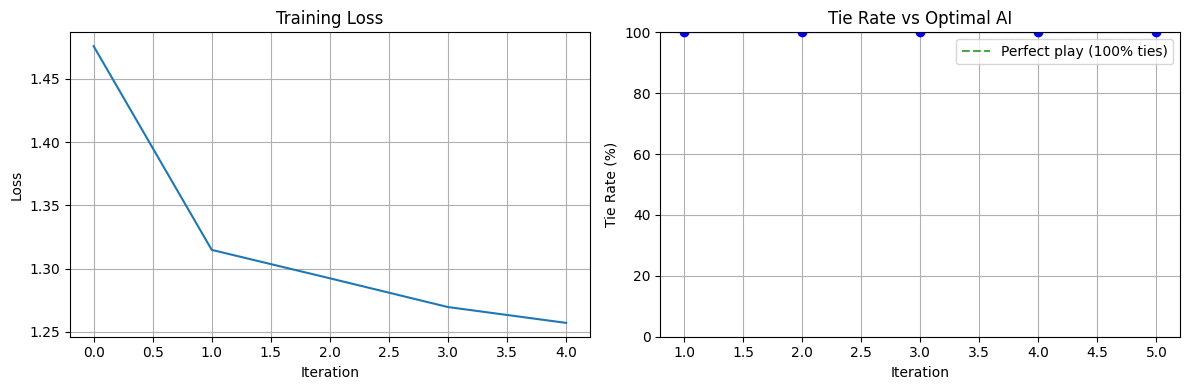

In [6]:
if __name__ == "__main__":
    # Run the demo
    demo_game()